In [1]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.insert(0,'../')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics


2024-10-29 16:21:49.010509: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 16:21:49.012494: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-29 16:21:49.037778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 16:21:49.037805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 16:21:49.038721: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0


In [19]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Datasets/dataset_reduced.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (602649, 17)


,turbine,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,R80736,16.480000,19.290001,-132.56,15.730000,20.680000,19.170000,19.920000,-137.95,-5.37,7.27,1.801180,29.480000,-137.95,-137.95,10823.5,2043069.9
602645,R80736,16.740000,19.059999,-132.56,15.600000,20.799999,19.299999,20.049999,-138.02,-5.44,7.23,1.798038,29.379999,-138.02,-138.02,10843.5,2043060.1
602646,R80736,17.370001,17.000000,-158.05,16.389999,21.010000,19.920000,20.469999,-156.45,1.60,8.87,1.801180,32.730000,-156.45,-156.45,10853.3,2048070.1
602647,R80711,16.820000,16.000000,-117.44,15.170000,21.120001,19.840000,20.480000,-122.41,-4.99,9.31,1.801180,26.010000,-122.41,-122.41,10817.3,2041980.0
602648,R80736,17.610001,17.000000,-134.75,16.709999,21.280001,19.719999,20.500000,-140.38,-5.62,10.31,1.799085,27.200001,-140.38,-140.38,10837.3,2043120.0


In [20]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine                0
theta                  0
hub_temperature        0
nacelle_angle          0
nacelle_temperature    0
V1                     0
V2                     0
V                      0
Wind_angle             0
Vane_angle             0
Out_temperature        0
W                      0
Rotor_temperature      0
Wind_angle_c           0
nacelle_angle_c        0
T                      0
P                      0
dtype: int64


In [21]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,16.480000,19.290001,-132.56,15.730000,20.680000,19.170000,19.920000,-137.95,-5.37,7.27,1.801180,29.480000,-137.95,-137.95,10823.5,2043069.9
602645,16.740000,19.059999,-132.56,15.600000,20.799999,19.299999,20.049999,-138.02,-5.44,7.23,1.798038,29.379999,-138.02,-138.02,10843.5,2043060.1
602646,17.370001,17.000000,-158.05,16.389999,21.010000,19.920000,20.469999,-156.45,1.60,8.87,1.801180,32.730000,-156.45,-156.45,10853.3,2048070.1
602647,16.820000,16.000000,-117.44,15.170000,21.120001,19.840000,20.480000,-122.41,-4.99,9.31,1.801180,26.010000,-122.41,-122.41,10817.3,2041980.0
602648,17.610001,17.000000,-134.75,16.709999,21.280001,19.719999,20.500000,-140.38,-5.62,10.31,1.799085,27.200001,-140.38,-140.38,10837.3,2043120.0


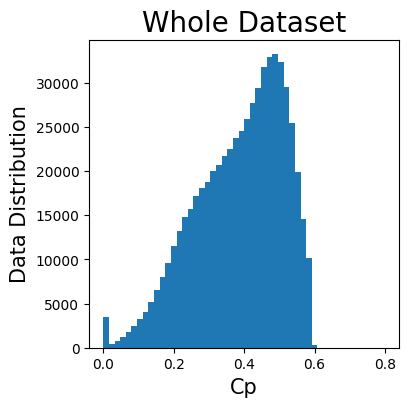

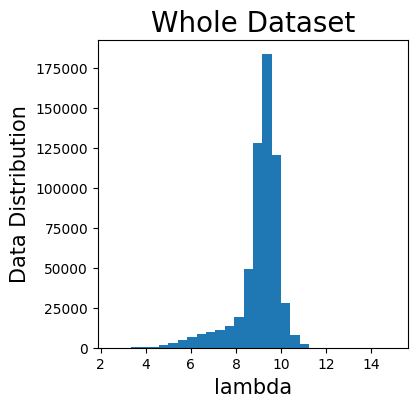

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P,Cp,lambda
602644,16.480000,19.290001,-132.56,15.730000,20.680000,19.170000,19.920000,-137.95,-5.37,7.27,1.801180,29.480000,-137.95,-137.95,10823.5,2043069.9,0.079908,3.707248
602645,16.740000,19.059999,-132.56,15.600000,20.799999,19.299999,20.049999,-138.02,-5.44,7.23,1.798038,29.379999,-138.02,-138.02,10843.5,2043060.1,0.078364,3.676787
602646,17.370001,17.000000,-158.05,16.389999,21.010000,19.920000,20.469999,-156.45,1.60,8.87,1.801180,32.730000,-156.45,-156.45,10853.3,2048070.1,0.073819,3.607639
602647,16.820000,16.000000,-117.44,15.170000,21.120001,19.840000,20.480000,-122.41,-4.99,9.31,1.801180,26.010000,-122.41,-122.41,10817.3,2041980.0,0.073492,3.605878
602648,17.610001,17.000000,-134.75,16.709999,21.280001,19.719999,20.500000,-140.38,-5.62,10.31,1.799085,27.200001,-140.38,-140.38,10837.3,2043120.0,0.073318,3.598171


In [22]:
# Add Cp and lambda to the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

Cp_data = Cp_fromP(dataset['P'][:],dataset['V'][:])
dataset['Cp'] = Cp_data
lambd_data = lambd(dataset['V'][:], dataset['W'][:])
dataset['lambda'] = lambd_data

plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

dataset.tail()

In [23]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-0.081045,5.978549,-1.08,-1.000000,-0.990000,-0.900000,9.276000e+01
hub_temperature,602649.0,19.060174,5.838598,4.05,14.170000,18.719999,23.000000,3.900000e+01
nacelle_angle,602649.0,-28.785794,111.742447,-180.00,-130.160000,-59.269990,55.330002,1.799900e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.49,20.639999,25.110001,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.00,4.950000,5.870000,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.00,4.990000,5.900000,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,0.23,4.970000,5.890000,7.130000,2.050000e+01
Wind_angle,602649.0,-28.404289,112.121101,-180.00,-130.640000,-57.989990,56.000000,1.799900e+02
Vane_angle,602649.0,-0.184985,9.427393,-179.34,-5.310000,-0.460000,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.95,5.960000,10.910000,16.330000,3.828000e+01


In [24]:
# Normalization 
# Cp in the range [0,1]. Originally, it was in [0,Cp_max]
# Rest of the variables with mean 0 and std 1

print(dataset.describe().transpose()[['mean', 'std']])

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )

column_name = dataset.columns.values
Cp_column = column_name[5]
#print(Cp_column)

Cp_max = 0.5926
dataset_norm = dataset.copy()
icol = 0
for col in column_name:
    if(col!='Cp'): # mean 0 and std 1
        dataset_norm[col]=(dataset[col]-x_mean[icol])/x_std[icol]        
    else: # Cp in [0,1]
        dataset_norm[col]=dataset[col]/Cp_max
    icol = icol+1

print()
print("Normalized dataset")
print(dataset_norm.describe().transpose()[['mean', 'std']])

                              mean            std
theta                    -0.081045       5.978549
hub_temperature          19.060174       5.838598
nacelle_angle           -28.785794     111.742447
nacelle_temperature      24.595032       6.192875
V1                        6.306669       2.018830
V2                        6.321526       1.956744
V                         6.314169       1.982688
Wind_angle              -28.404289     112.121101
Vane_angle               -0.184985       9.427393
Out_temperature          11.473260       7.091906
W                         1.362470       0.318853
Rotor_temperature        28.486577       4.714501
Wind_angle_c            -29.302312     111.841797
nacelle_angle_c         -29.710568     111.627225
T                      2646.532389    2258.267705
P                    444860.879260  446349.165241
Cp                        0.386876       0.124435
lambda                    9.004813       1.167138

Normalized dataset
                             m

In [25]:
# load existing Pphys model
from keras import backend as K
from keras.layers import Input, Lambda
from keras.layers import Concatenate
V_mean = 6.314169410268349
V_std = 1.9826865496833004

Pphys_model = tf.keras.models.load_model('../Models/Pphys_Cp2D.h5')
Pphys_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xphys (InputLayer)          [(None, 3)]                  0         []                            
                                                                                                  
 lambda_17 (Lambda)          (None, 1)                    0         ['xphys[0][0]']               
                                                                                                  
 lambda_15 (Lambda)          (None, 1)                    0         ['xphys[0][0]']               
                                                                                                  
 tf.math.multiply_13 (TFOpL  (None, 1)                    0         ['lambda_17[0][0]']           
 ambda)                                                                                     

In [26]:
# Define input features of P_phys model
dataset_copy = dataset_norm.copy()
xphys = dataset_copy[['V','theta','W']]

# Evaluate power in normalized units
P_phys = Pphys_model.predict(xphys).flatten()

18833/18833 [==============================] - 9s 452us/step


In [27]:
# Add physical and residual power to the dataset
dataset['P_phys'] = P_phys
dataset.describe().transpose()
#dataset['P_res'] = dataset['P_phys'] - dataset['P']
dataset['P_res'] = dataset['P'] - dataset['P_phys']
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-0.081045,5.978549,-1.08,-1.000000,-0.990000,-0.900000,9.276000e+01
hub_temperature,602649.0,19.060174,5.838598,4.05,14.170000,18.719999,23.000000,3.900000e+01
nacelle_angle,602649.0,-28.785794,111.742447,-180.00,-130.160000,-59.269990,55.330002,1.799900e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.49,20.639999,25.110001,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.00,4.950000,5.870000,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.00,4.990000,5.900000,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,0.23,4.970000,5.890000,7.130000,2.050000e+01
Wind_angle,602649.0,-28.404289,112.121101,-180.00,-130.640000,-57.989990,56.000000,1.799900e+02
Vane_angle,602649.0,-0.184985,9.427393,-179.34,-5.310000,-0.460000,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.95,5.960000,10.910000,16.330000,3.828000e+01


In [28]:
# Normalize dataset
#P_phys_norm = (P_phys - dataset['P_phys'].mean())/dataset['P_phys'].std() # Normalize Power  
P_phys_norm = (P_phys - P_phys.mean())/P_phys.std() # Normalize Power  
dataset_norm['P_phys'] = P_phys_norm
dataset_norm['P_res'] = ( dataset['P_res'] - dataset['P_res'].mean() )/dataset['P_res'].std()
dataset_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,1.071505e-16,1.000001,-0.167090,-0.153709,-0.152036,-0.136982,15.529038
hub_temperature,602649.0,7.081741e-16,1.000001,-2.570855,-0.837560,-0.058263,0.674790,3.415176
nacelle_angle,602649.0,4.527485e-18,1.000001,-1.353240,-0.907214,-0.272808,0.752766,1.868368
nacelle_temperature,602649.0,-3.561621e-16,1.000001,-3.730909,-0.638643,0.083155,0.706452,2.957428
V1,602649.0,5.070783e-16,1.000001,-3.123925,-0.672008,-0.216298,0.407826,7.416842
V2,602649.0,1.992093e-16,1.000001,-3.230637,-0.680481,-0.215422,0.418284,7.067088
V,602649.0,4.829317e-17,1.000001,-3.068649,-0.677954,-0.213937,0.411477,7.154853
Wind_angle,602649.0,-3.697446e-17,1.000001,-1.352072,-0.911834,-0.263873,0.752796,1.858655
Vane_angle,602649.0,-6.744066e-18,1.000001,-19.003680,-0.543631,-0.029172,0.528777,19.086414
Out_temperature,602649.0,7.949508e-16,1.000001,-2.597789,-0.777402,-0.079423,0.684829,3.779909


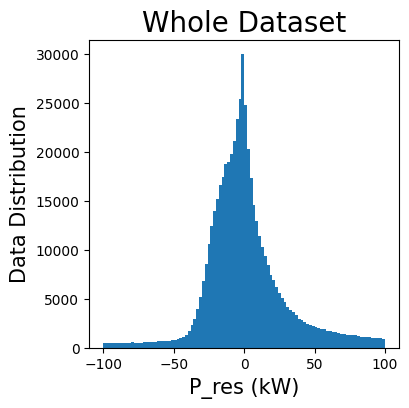

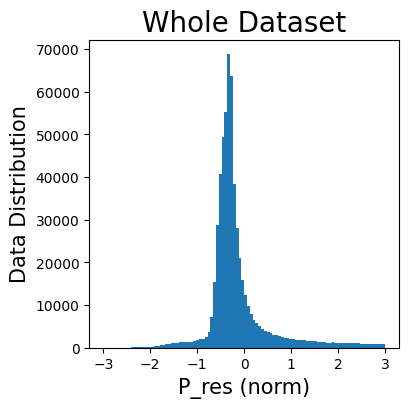

In [29]:
# Plot distribution of P_res in kW
Pres_data = dataset['P_res']
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pres_data/1000, range=[-100, 100], bins=100)
plt.xlabel('P_res (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Normalized Pres
Pres_norm = dataset_norm['P_res']
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pres_norm, range=[-3, 3], bins=100)
plt.xlabel('P_res (norm)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

In [30]:
# Correlation filter

# Create correlation matrix
corr_matrix = dataset_norm.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
print(upper)

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print('to_drop: ',to_drop)

# Drop features 
#dataset_norm.drop(to_drop, axis=1, inplace=True)

                     theta  hub_temperature  nacelle_angle  \
theta                  NaN         0.014784       0.016523   
hub_temperature        NaN              NaN       0.021629   
nacelle_angle          NaN              NaN            NaN   
nacelle_temperature    NaN              NaN            NaN   
V1                     NaN              NaN            NaN   
V2                     NaN              NaN            NaN   
V                      NaN              NaN            NaN   
Wind_angle             NaN              NaN            NaN   
Vane_angle             NaN              NaN            NaN   
Out_temperature        NaN              NaN            NaN   
W                      NaN              NaN            NaN   
Rotor_temperature      NaN              NaN            NaN   
Wind_angle_c           NaN              NaN            NaN   
nacelle_angle_c        NaN              NaN            NaN   
T                      NaN              NaN            NaN   
P       

In [31]:
# Drop features 
drop_list = ['V1','V2','Wind_angle','nacelle_angle']
dataset_norm.drop(drop_list, axis=1, inplace=True)
print(dataset_norm.columns)

Index(['theta', 'hub_temperature', 'nacelle_temperature', 'V', 'Vane_angle',
       'Out_temperature', 'W', 'Rotor_temperature', 'Wind_angle_c',
       'nacelle_angle_c', 'T', 'P', 'Cp', 'lambda', 'P_phys', 'P_res'],
      dtype='object')


In [32]:
# Second correlation filter

# Create correlation matrix
corr_matrix = dataset_norm.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
print(upper)

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print('to_drop: ',to_drop)

                     theta  hub_temperature  nacelle_temperature         V  \
theta                  NaN         0.014784             0.018402  0.110545   
hub_temperature        NaN              NaN             0.616204  0.135470   
nacelle_temperature    NaN              NaN                  NaN  0.439113   
V                      NaN              NaN                  NaN       NaN   
Vane_angle             NaN              NaN                  NaN       NaN   
Out_temperature        NaN              NaN                  NaN       NaN   
W                      NaN              NaN                  NaN       NaN   
Rotor_temperature      NaN              NaN                  NaN       NaN   
Wind_angle_c           NaN              NaN                  NaN       NaN   
nacelle_angle_c        NaN              NaN                  NaN       NaN   
T                      NaN              NaN                  NaN       NaN   
P                      NaN              NaN                  NaN

In [33]:
# Second Drop features 
drop_list = ['hub_temperature','nacelle_angle_c']
dataset_norm.drop(drop_list, axis=1, inplace=True)
print(dataset_norm.columns)

Index(['theta', 'nacelle_temperature', 'V', 'Vane_angle', 'Out_temperature',
       'W', 'Rotor_temperature', 'Wind_angle_c', 'T', 'P', 'Cp', 'lambda',
       'P_phys', 'P_res'],
      dtype='object')


In [34]:
# Split the data into training and test sets
train_dataset = dataset_norm.sample(frac=0.8, random_state=10)
test_dataset = dataset_norm.drop(train_dataset.index)

In [35]:
# Split input features from labels/targets

#train_features = train_dataset[['V','theta','W']]
#test_features = test_dataset[['V','theta','W']]

column_list = list(dataset_norm.columns)
print(column_list)
column_list.remove('T')
column_list.remove('P')
column_list.remove('Cp')
column_list.remove('lambda')
column_list.remove('P_phys')
column_list.remove('P_res')
print(column_list)

train_features = train_dataset[column_list[:]]
test_features = test_dataset[column_list[:]]
train_labels = train_dataset.pop('P_res')
test_labels = test_dataset.pop('P_res')

print(train_features.shape)
print(train_labels.shape)
n_inputs = len(column_list)
print('n_inputs: ',n_inputs)

['theta', 'nacelle_temperature', 'V', 'Vane_angle', 'Out_temperature', 'W', 'Rotor_temperature', 'Wind_angle_c', 'T', 'P', 'Cp', 'lambda', 'P_phys', 'P_res']
['theta', 'nacelle_temperature', 'V', 'Vane_angle', 'Out_temperature', 'W', 'Rotor_temperature', 'Wind_angle_c']
(482119, 8)
(482119,)
n_inputs:  8


In [36]:
# Save dataset for the subsequent explainability analysis
train_dataset[column_list[:]].to_csv('../Datasets/Dataset_train_CF.csv')
test_dataset[column_list[:]].to_csv('../Datasets/Dataset_test_CF.csv')

In [37]:
# Define the hypermodel to optimize hyperparameters
 
def model_builder(hp):
  
  input = tf.keras.Input(shape=(n_inputs,))
  model = keras.Sequential()

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=256, step=2, sampling='log')
  
  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  model.add(input)
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
  # final linear 1-unit layer
  #model.add(keras.layers.Dense(1,activation=hp_activation)) 
  model.add(keras.layers.Dense(1)) 

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                #metrics=['accuracy'])
                loss='mean_absolute_error')   

  return model

In [38]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(model_builder,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=20,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='Pres_Cp2D_CF')

In [39]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

x = train_features  # input features are lambda and theta

# if batch_size is not specified, 32 is the default value
batch_size = 128
tuner.search(x, train_labels, epochs=20, validation_split=0.2, batch_size=batch_size, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: {best_hps.get('layers')}
n_units: {best_hps.get('units')}
learning_rate: {best_hps.get('learning_rate')}
activation_function: {best_hps.get('activation')}
""")

Trial 30 Complete [00h 00m 43s]
val_loss: 0.27865704894065857

Best val_loss So Far: 0.15579469501972198
Total elapsed time: 00h 09m 32s

The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: 2
n_units: 128
learning_rate: 0.001
activation_function: relu



In [40]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)
# Create a callback to stop training early after reaching a constant value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

# Build the model with the optimal hyperparameters and train it on the data for 500 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x, train_labels, epochs=150, batch_size=batch_size, 
                    validation_split=0.2, callbacks=[reduce_lr,stop_early])

Epoch 1/150
3014/3014 [==============================] - 3s 795us/step - loss: 0.2474 - val_loss: 0.1992 - lr: 0.0010
Epoch 2/150
3014/3014 [==============================] - 2s 774us/step - loss: 0.1920 - val_loss: 0.1875 - lr: 0.0010
Epoch 3/150
3014/3014 [==============================] - 2s 766us/step - loss: 0.1825 - val_loss: 0.1820 - lr: 0.0010
Epoch 4/150
3014/3014 [==============================] - 2s 769us/step - loss: 0.1782 - val_loss: 0.1824 - lr: 0.0010
Epoch 5/150
3014/3014 [==============================] - 2s 787us/step - loss: 0.1755 - val_loss: 0.1745 - lr: 0.0010
Epoch 6/150
3014/3014 [==============================] - 2s 780us/step - loss: 0.1737 - val_loss: 0.1765 - lr: 0.0010
Epoch 7/150
3014/3014 [==============================] - 2s 765us/step - loss: 0.1717 - val_loss: 0.1696 - lr: 0.0010
Epoch 8/150
3014/3014 [==============================] - 2s 765us/step - loss: 0.1695 - val_loss: 0.1689 - lr: 0.0010
Epoch 9/150
3014/3014 [==============================] -

Best epoch: 141


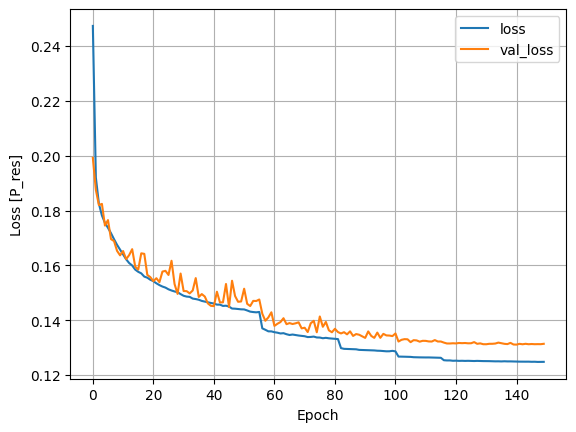

In [41]:
# Plot the loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss [P_res]')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [42]:
model.save('../Models/Pres_Cp2D_CF.h5')

/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
# load residual model 

Pres_model = tf.keras.models.load_model('../Models/Pres_Cp2D_CF.h5')
Pres_model.summary()
model = Pres_model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               1152      
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17793 (69.50 KB)
Trainable params: 17793 (69.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


3767/3767 [==============================] - 2s 411us/step


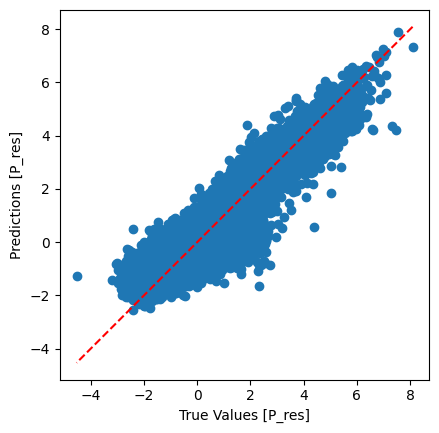

Test MAE: 0.13171295821666718


In [45]:
# Evaluate the model on P_res data

# Pred vs True values

#test_pred = model.predict(test_features[['lambda', 'theta']]).flatten()
#test_pred = model.predict(test_features[['V','theta','W']]).flatten()
test_pred = model.predict(test_features[column_list[:]]).flatten()

a = plt.axes(aspect='equal')
p1 = max(max(test_pred), max(test_labels))
p2 = min(min(test_pred), min(test_labels))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(test_labels, test_pred)
plt.xlabel('True Values [P_res]')
plt.ylabel('Predictions [P_res]')
#lims = [-10, 10]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)
plt.show()

#test_result = model.evaluate(test_features[['lambda','theta']], test_labels, verbose=0)
#test_result = model.evaluate(test_features[['V','theta','W']], test_labels, verbose=0)
test_result = model.evaluate(test_features[column_list[:]], test_labels, verbose=0)
print("Test MAE: "+str(test_result))

3767/3767 [==============================] - 2s 429us/step


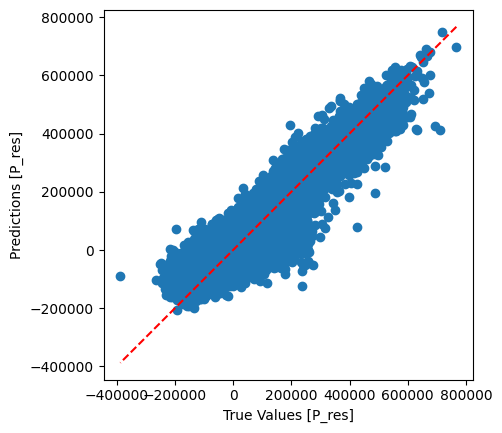


Test MAE: 12044.416344951
Test RMSE: 25038.192186120014
Test MAPE: 31.686209060649873 %
Test R2: 0.9265130138335915


In [46]:
# Evaluate P_res with original units

# Pred vs True values

y_pred = model.predict(test_features[column_list[:]]).flatten()
y_true = test_labels

y_pred = y_pred * dataset['P_res'].std() + dataset['P_res'].mean()
y_true = y_true * dataset['P_res'].std() + dataset['P_res'].mean()

a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(y_true, y_pred)
plt.xlabel('True Values [P_res]')
plt.ylabel('Predictions [P_res]')
#lims = [-300000, 300000]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)
plt.show()

P_cutoff = 25000
y_pred_nonzero = y_pred[abs(y_true)>P_cutoff]
y_true_nonzero = y_true[abs(y_true)>P_cutoff]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

3767/3767 [==============================] - 2s 422us/step
-387527.25
766933.5937499999
27572.164469527477
47284.253765302594



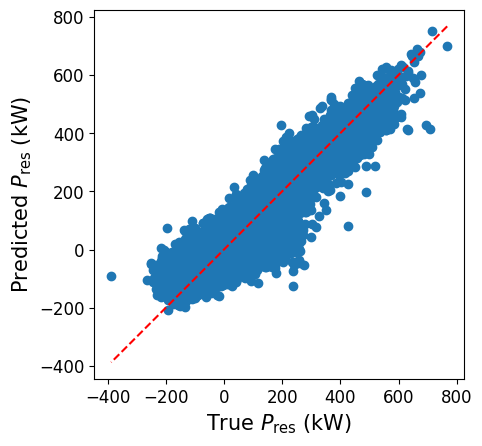


Test MAE: 12044.416344951
Test RMSE: 25038.192186120014
Test MAPE: 31.686209060649873 %
Test R2: 0.9265130138335915


In [47]:
# Evaluate P_res with original units

# Pred vs True values

y_pred = model.predict(test_features[column_list[:]]).flatten()
y_true = test_labels

y_pred = y_pred * dataset['P_res'].std() + dataset['P_res'].mean()
y_true = y_true * dataset['P_res'].std() + dataset['P_res'].mean()

print(np.min(y_true))
print(np.max(y_true))
print(np.mean(y_true))
print(np.mean(abs(y_true)))
print()

a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1/1000, p2/1000], [p1/1000, p2/1000], 'r--')
plt.scatter(y_true/1000, y_pred/1000)
plt.xlabel('True $P_\\text{res}$ (kW)',fontsize=15)
plt.ylabel('Predicted $P_\\text{res}$ (kW)',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#lims = [-300000/1000, 300000/1000]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)
plt.show()

P_cutoff = 25000
y_pred_nonzero = y_pred[abs(y_true)>P_cutoff]
y_true_nonzero = y_true[abs(y_true)>P_cutoff]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

3767/3767 [==============================] - 2s 430us/step


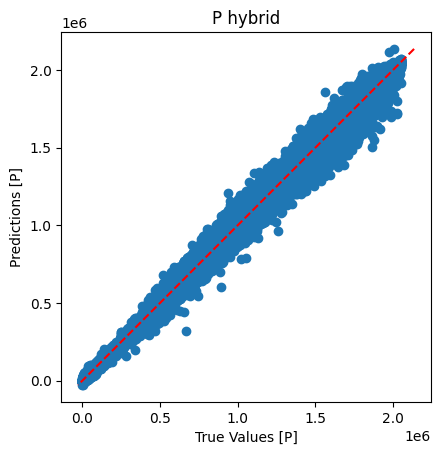


Test MAE: 12044.439318113546
Test RMSE: 25038.234583936544
Test MAPE: 2.467210132078829 %
Test R2: 0.996876975195841


In [48]:
# Compare P data with P_pred = P_phys + P_res 

# Calculate P_phys in original units
xphys = test_features[['V','theta','W']]
P_phys = Pphys_model.predict(xphys).flatten()

# Calculate P_res
P_res = model.predict(test_features[column_list[:]]).flatten()
P_res = P_res * dataset['P_res'].std() + dataset['P_res'].mean() # convert to original units

# Predicted P as sum of physical P plus residual P
P_pred = P_phys + P_res # in original units (Watts)
#P_pred = P_phys - P_res # in original units (Watts)

# Power from data
P_true = test_dataset.loc[:,'P'] # P in normalized units
P_true = P_true * dataset['P'].std() + dataset['P'].mean()

y_true = P_true
y_pred = P_pred

# Plot
a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(y_true, y_pred)
plt.xlabel('True Values [P]')
plt.ylabel('Predictions [P]')
plt.title('P hybrid')
plt.show()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

# Metrics
P_cutoff = 25000
y_pred_nonzero = y_pred[abs(y_true)>P_cutoff]
y_true_nonzero = y_true[abs(y_true)>P_cutoff]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

(602649,)
(602649,)
27035.692802908743
91444.38047835056


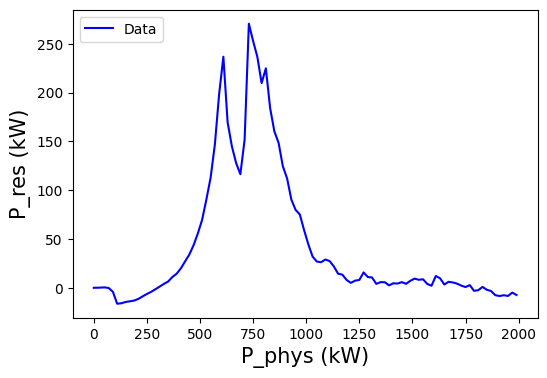

In [49]:
# Plot P_res vs P_phys from data

Pres_array = np.array(dataset['P_res'])
Pphys_array = np.array(dataset['P_phys'])

print(Pres_array.shape)
print(Pphys_array.shape)
print(np.mean(Pres_array))
print(np.std(Pres_array))


# Estimation of the curve
Pmin = 0
Pmax = 2*10**6
nbins = 100
y_estimated = np.zeros(nbins)
x_estimated = np.zeros(nbins)
dP = (Pmax-Pmin)/nbins

for i in range(1,nbins):
    Pl = Pmin + i*dP
    Pr = Pl + dP

    # Mean Pres in the bin i
    x_estimated[i] = (Pl+Pr)/2.0
    x_subset = (Pl<Pphys_array) & (Pphys_array<Pr) # subset of P points within the bin 
    yi = Pres_array[x_subset]

    if(len(yi)>0):
        y_estimated[i] = statistics.mean(yi)

# Plot P vs v of all data
plt.figure(figsize=(6,4))
plt.xlabel('P_phys (kW)',fontsize=15)
plt.ylabel('P_res (kW)',fontsize=15)
plt.plot(x_estimated/1000, y_estimated/1000, 'b-',label='Data')
#plt.xlim([0,18])
#plt.ylim([0,0.7])
#l1 = plt.legend(bbox_to_anchor=(0.7, 0.7), borderaxespad=0)
plt.legend(loc='upper left')
plt.show()

3767/3767 [==============================] - 2s 432us/step
(120530,)
(120530,)
(120530,)
-206583.14
749708.9
25661.982
43980.176


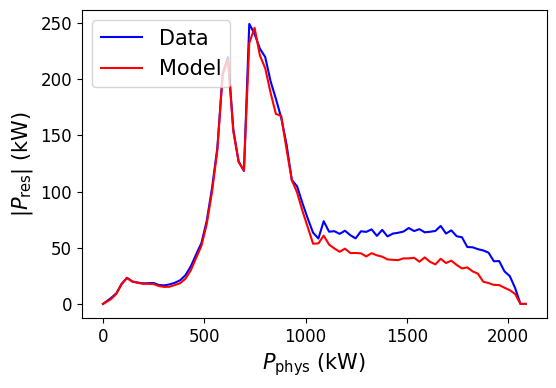

In [50]:
# Plot P_res vs P_phys from data and model on the test set

# Calculate P_phys with original units
P_phys = Pphys_model.predict(test_features[['V','theta','W']]).flatten()

# Calculate P_res from the model
Pres_pred = model.predict(test_features[column_list[:]]).flatten()
Pres_pred = Pres_pred * dataset['P_res'].std() + dataset['P_res'].mean() # convert to original units

# Load P_res from test data
Pres_true = test_labels # P in normalized units
Pres_true = Pres_true * dataset['P_res'].std() + dataset['P_res'].mean()

Pres_pred_array = np.array(Pres_pred)
Pres_true_array = np.array(Pres_true)
Pphys_array = np.array(P_phys)

print(Pres_pred_array.shape)
print(Pres_true_array.shape)
print(Pphys_array.shape)
#print(np.mean(Pres_pred_array))
#print(np.mean(Pres_true_array))
print(np.min(Pres_pred_array))
print(np.max(Pres_pred_array))
print(np.mean(Pres_pred_array))
print(np.mean(abs(Pres_pred_array)))

# Estimation of the curve
Pmin = 0
Pmax = 2.1*10**6
nbins = 80
y_pred_estimated = np.zeros(nbins)
y_true_estimated = np.zeros(nbins)
ystd_pred_estimated = np.zeros(nbins)
ystd_true_estimated = np.zeros(nbins)
x_estimated = np.zeros(nbins)
dP = (Pmax-Pmin)/nbins

for i in range(1,nbins):
    Pl = Pmin + i*dP
    Pr = Pl + dP

    # Mean Pres in the bin i
    x_estimated[i] = (Pl+Pr)/2.0
    x_subset = (Pl<Pphys_array) & (Pphys_array<Pr) # subset of P points within the bin 
    ypred_i = Pres_pred_array[x_subset]
    ytrue_i = Pres_true_array[x_subset]
    if(len(ypred_i)>30): #>30 to avoid some outliers
        y_pred_estimated[i] = statistics.mean(abs(ypred_i))
        y_true_estimated[i] = statistics.mean(abs(ytrue_i))
        #ystd_pred_estimated[i] = np.std(ypred_i)
        #ystd_true_estimated[i] = np.std(ytrue_i)

# Plot P vs v of all data
plt.figure(figsize=(6,4))
plt.xlabel('$P_\\text{phys}$ (kW)',fontsize=15)
plt.ylabel('|$P_\\text{res}$| (kW)',fontsize=15)
plt.plot(x_estimated/1000, y_true_estimated/1000, 'b-',label='Data')
plt.plot(x_estimated/1000, y_pred_estimated/1000, 'r-',label='Model')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.errorbar(x_estimated/1000,y_pred_estimated/1000, yerr=ystd_pred_estimated/1000, color='orange')
#plt.xlim([0,18])
#plt.ylim([0,0.7])
#l1 = plt.legend(bbox_to_anchor=(0.7, 0.7), borderaxespad=0)
plt.legend(loc='upper left',fontsize=15)
plt.show()

18833/18833 [==============================] - 8s 429us/step
(602649,)
(602649,)
(602649,)
25287.648
27035.692802908743


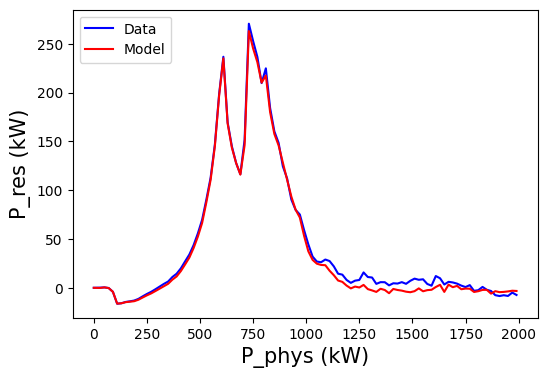

In [52]:
# Plot P_res vs P_phys from data and model on the whole dataset

# Calculate P_phys from Cp empirical model
P_phys = Pphys_model.predict(dataset_norm[['V','theta','W']]).flatten() # calculate Power in original units

# Calculate P_res from the model
Pres_pred = model.predict(dataset_norm[column_list[:]]).flatten()
Pres_pred = Pres_pred * dataset['P_res'].std() + dataset['P_res'].mean() # convert to original units

# Load P_res from test data
Pres_true = dataset_norm.loc[:,'P_res'] # P in normalized units
Pres_true = Pres_true * dataset['P_res'].std() + dataset['P_res'].mean()

Pres_pred_array = np.array(Pres_pred)
Pres_true_array = np.array(Pres_true)
Pphys_array = np.array(P_phys)

print(Pres_pred_array.shape)
print(Pres_true_array.shape)
print(Pphys_array.shape)
print(np.mean(Pres_pred_array))
print(np.mean(Pres_true_array))

# Estimation of the curve
Pmin = 0
Pmax = 2*10**6
#nbins = 100
nbins = 100
y_pred_estimated = np.zeros(nbins)
y_true_estimated = np.zeros(nbins)
x_estimated = np.zeros(nbins)
dP = (Pmax-Pmin)/nbins

for i in range(1,nbins):
    Pl = Pmin + i*dP
    Pr = Pl + dP

    # Mean Pres in the bin i
    x_estimated[i] = (Pl+Pr)/2.0
    x_subset = (Pl<Pphys_array) & (Pphys_array<Pr) # subset of P points within the bin 
    ypred_i = Pres_pred_array[x_subset]
    ytrue_i = Pres_true_array[x_subset]
    if(len(ypred_i)>0):
        y_pred_estimated[i] = statistics.mean(ypred_i)
        y_true_estimated[i] = statistics.mean(ytrue_i)

# Plot P vs v of all data
plt.figure(figsize=(6,4))
plt.xlabel('P_phys (kW)',fontsize=15)
plt.ylabel('P_res (kW)',fontsize=15)
plt.plot(x_estimated/1000, y_true_estimated/1000, 'b-',label='Data')
plt.plot(x_estimated/1000, y_pred_estimated/1000, 'r-',label='Model')
#plt.xlim([0,18])
#plt.ylim([0,0.7])
#l1 = plt.legend(bbox_to_anchor=(0.7, 0.7), borderaxespad=0)
plt.legend(loc='upper left')
plt.show()

['theta', 'hub_temperature', 'nacelle_angle', 'nacelle_temperature', 'V1', 'V2', 'V', 'Wind_angle', 'Vane_angle', 'Out_temperature', 'W', 'Rotor_temperature', 'Wind_angle_c', 'nacelle_angle_c', 'T', 'P', 'Cp', 'lambda', 'P_phys', 'P_res']
['theta', 'nacelle_temperature', 'V', 'Vane_angle', 'Out_temperature', 'W', 'Rotor_temperature', 'Wind_angle_c']
18833/18833 [==============================] - 8s 420us/step


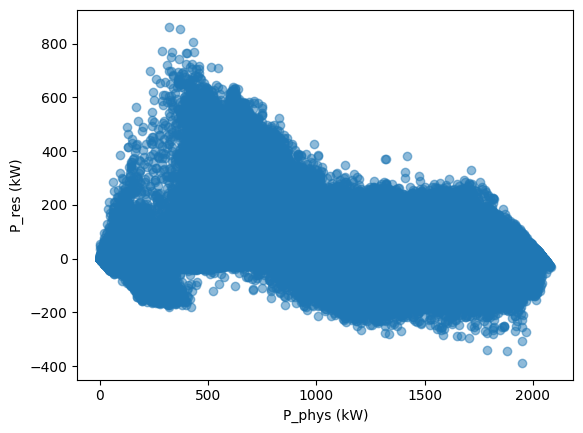

/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


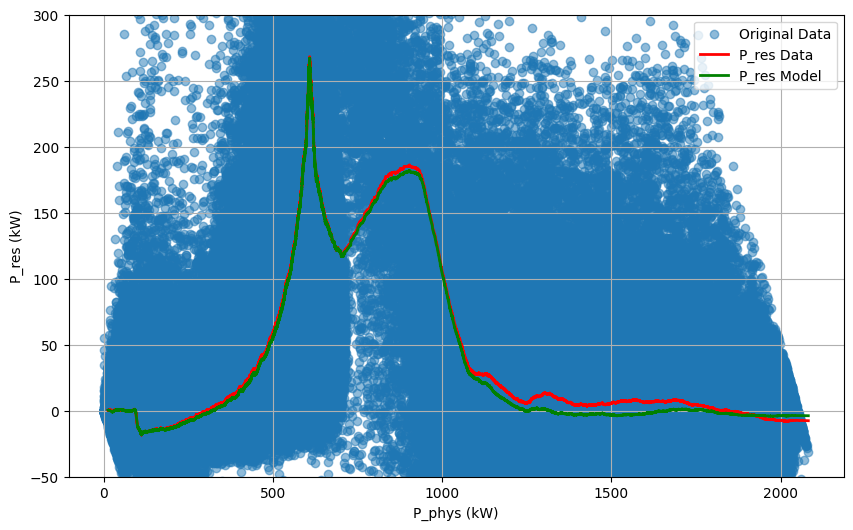

In [54]:
# Scatter plot P_res vs P_phys

Pres_model = tf.keras.models.load_model('../Models/Pres_Cp2D_CF.h5')
column_list = list(dataset.columns)
print(column_list)
column_list.remove('T')
column_list.remove('P')
column_list.remove('Cp')
column_list.remove('lambda')
column_list.remove('P_phys')
column_list.remove('P_res')
remove_list = ['V1','V2','Wind_angle','nacelle_angle','hub_temperature','nacelle_angle_c']
column_list = [item for item in column_list if item not in remove_list]
print(column_list)
Pres_pred = Pres_model.predict(dataset_norm[column_list[:]]).flatten()
Pres_pred = Pres_pred * dataset['P_res'].std() + dataset['P_res'].mean() # convert to original units

x = dataset['P_phys'].to_numpy()
y = dataset['P_res'].to_numpy()
yp = Pres_pred#.to_numpy()

# Normal scatter plot
plt.scatter(x/1000, y/1000, label='Original Data', alpha=0.5)
plt.xlabel('P_phys (kW)')
plt.ylabel('P_res (kW)')
plt.show()

# Sort the x and corresponding y values
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
yp_sorted = yp[sorted_indices]

# Ensure x_sorted and y_sorted are 1D vectors (it should be, but we can use ravel() to be sure)
y_sorted = y_sorted.ravel()  # This ensures it's a 1D array
yp_sorted = yp_sorted.ravel()  # This ensures it's a 1D array

# Calculate moving average
window_size = 5000
# Use np.convolve with 'valid' mode to handle edges properly
y_smoothed = np.convolve(y_sorted, np.ones(window_size)/window_size, mode='valid')
yp_smoothed = np.convolve(yp_sorted, np.ones(window_size)/window_size, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted/1000, y_sorted/1000, label='Original Data', alpha=0.5)
plt.plot(x_sorted[window_size-1:]/1000, y_smoothed/1000, color='red', label='P_res Data', linewidth=2)
plt.plot(x_sorted[window_size-1:]/1000, yp_smoothed/1000, color='green', label='P_res Model', linewidth=2)
#plt.title('Moving Average Smoothing with Unordered Data')
plt.xlabel('P_phys (kW)')
plt.ylabel('P_res (kW)')
plt.ylim((-50,300))
plt.legend()
plt.grid()
plt.show()


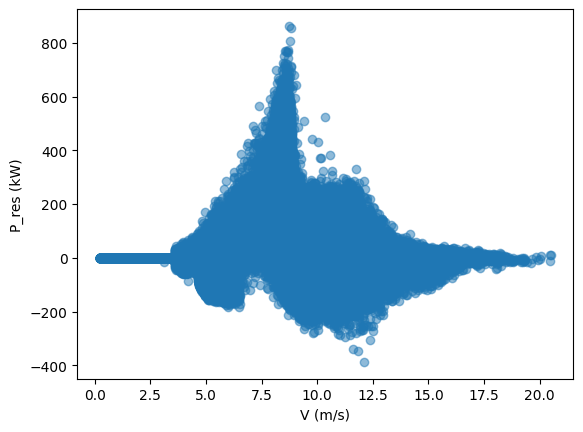

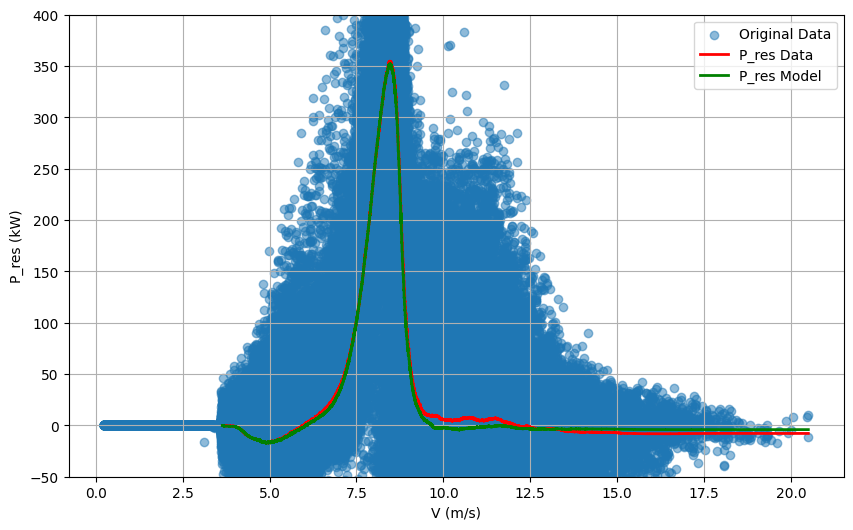

In [55]:
# Scatter P_res vs V

x = dataset['V'].to_numpy()
y = dataset['P_res'].to_numpy()
yp = Pres_pred#.to_numpy()

# Normal scatter plot
plt.scatter(x, y/1000, label='Original Data', alpha=0.5)
plt.xlabel('V (m/s)')
plt.ylabel('P_res (kW)')
plt.show()

# Sort the x and corresponding y values
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
yp_sorted = yp[sorted_indices]

# Ensure x_sorted and y_sorted are 1D vectors (it should be, but we can use ravel() to be sure)
y_sorted = y_sorted.ravel()  # This ensures it's a 1D array
yp_sorted = yp_sorted.ravel()  # This ensures it's a 1D array

# Calculate moving average
window_size = 5000
# Use np.convolve with 'valid' mode to handle edges properly
y_smoothed = np.convolve(y_sorted, np.ones(window_size)/window_size, mode='valid')
yp_smoothed = np.convolve(yp_sorted, np.ones(window_size)/window_size, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted/1000, label='Original Data', alpha=0.5)
plt.plot(x_sorted[window_size-1:], y_smoothed/1000, color='red', label='P_res Data', linewidth=2)
plt.plot(x_sorted[window_size-1:], yp_smoothed/1000, color='green', label='P_res Model', linewidth=2)
#plt.title('Moving Average Smoothing with Unordered Data')
plt.xlabel('V (m/s)')
plt.ylabel('P_res (kW)')
plt.ylim((-50,400))
plt.legend()
plt.grid()
plt.show()



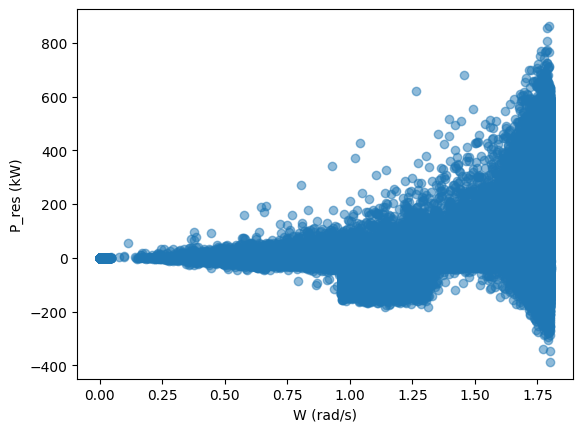

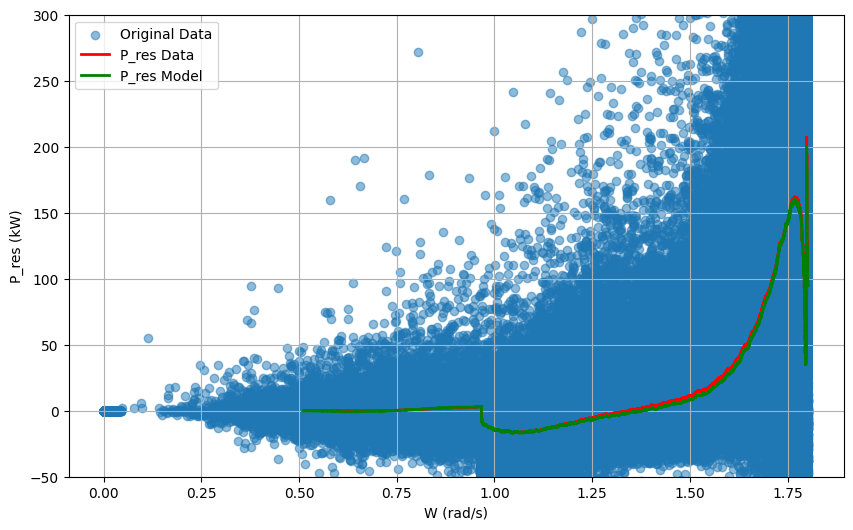

In [56]:
# Scatter P_res vs W

x = dataset['W'].to_numpy()
y = dataset['P_res'].to_numpy()
yp = Pres_pred#.to_numpy()

# Normal scatter plot
plt.scatter(x, y/1000, label='Original Data', alpha=0.5)
plt.xlabel('W (rad/s)')
plt.ylabel('P_res (kW)')
plt.show()

# Sort the x and corresponding y values
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
yp_sorted = yp[sorted_indices]

# Ensure x_sorted and y_sorted are 1D vectors (it should be, but we can use ravel() to be sure)
y_sorted = y_sorted.ravel()  # This ensures it's a 1D array
yp_sorted = yp_sorted.ravel()  # This ensures it's a 1D array

# Calculate moving average
window_size = 5000
# Use np.convolve with 'valid' mode to handle edges properly
y_smoothed = np.convolve(y_sorted, np.ones(window_size)/window_size, mode='valid')
yp_smoothed = np.convolve(yp_sorted, np.ones(window_size)/window_size, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted/1000, label='Original Data', alpha=0.5)
plt.plot(x_sorted[window_size-1:], y_smoothed/1000, color='red', label='P_res Data', linewidth=2)
plt.plot(x_sorted[window_size-1:], yp_smoothed/1000, color='green', label='P_res Model', linewidth=2)
#plt.title('Moving Average Smoothing with Unordered Data')
plt.xlabel('W (rad/s)')
plt.ylabel('P_res (kW)')
plt.ylim((-50,300))
plt.legend()
plt.grid()
plt.show()

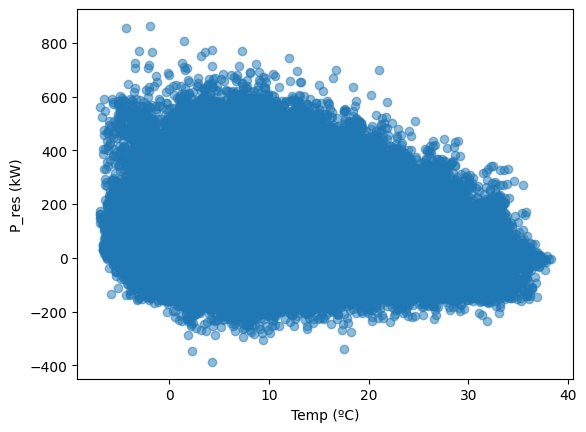

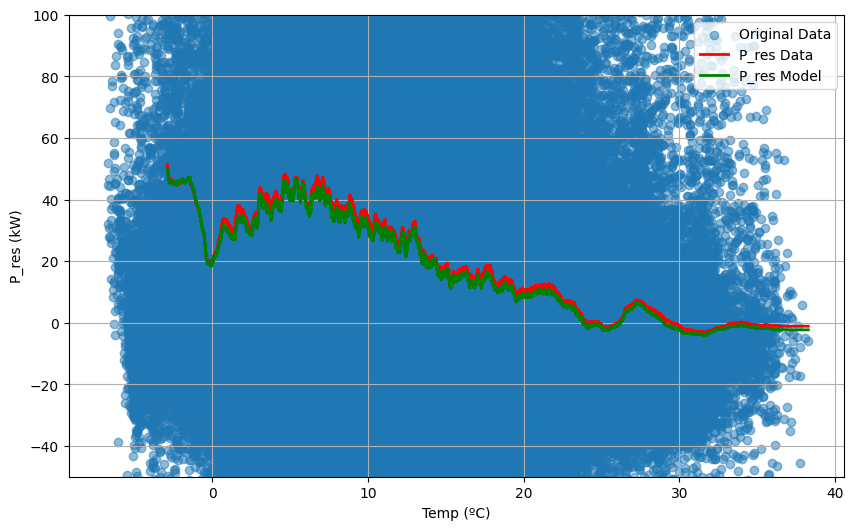

In [57]:
# Scatter P_res vs T

x = dataset['Out_temperature'].to_numpy()
y = dataset['P_res'].to_numpy()
yp = Pres_pred#.to_numpy()

# Normal scatter plot
plt.scatter(x, y/1000, label='Original Data', alpha=0.5)
plt.xlabel('Temp (ºC)')
plt.ylabel('P_res (kW)')
plt.show()

# Sort the x and corresponding y values
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
yp_sorted = yp[sorted_indices]

# Ensure x_sorted and y_sorted are 1D vectors (it should be, but we can use ravel() to be sure)
y_sorted = y_sorted.ravel()  # This ensures it's a 1D array
yp_sorted = yp_sorted.ravel()  # This ensures it's a 1D array

# Calculate moving average
window_size = 5000
# Use np.convolve with 'valid' mode to handle edges properly
y_smoothed = np.convolve(y_sorted, np.ones(window_size)/window_size, mode='valid')
yp_smoothed = np.convolve(yp_sorted, np.ones(window_size)/window_size, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted/1000, label='Original Data', alpha=0.5)
plt.plot(x_sorted[window_size-1:], y_smoothed/1000, color='red', label='P_res Data', linewidth=2)
plt.plot(x_sorted[window_size-1:], yp_smoothed/1000, color='green', label='P_res Model', linewidth=2)
#plt.title('Moving Average Smoothing with Unordered Data')
plt.xlabel('Temp (ºC)')
plt.ylabel('P_res (kW)')
plt.ylim((-50,100))
plt.legend()
plt.grid()
plt.show()